In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pyTMD.time import convert_calendar_dates, datetime_to_list
from pyTMD.io import model, GOT, ATLAS
from pyTMD.predict import time_series, infer_minor, map
from datetime import datetime, timedelta

In [12]:
lon = 122.26672
lat = 23.76175

# Model parameters
model_directory = '/media/X/temp/tide/GOT4.10/'
model_format = 'netcdf'
compressed = False
model_name = 'GOT4.10'


In [13]:
# Create model object
def get_tide_model(model_name, model_directory, model_format, compressed=False):
    return model(model_directory, format=model_format, compressed=compressed).elevation(model_name)

tide_model = get_tide_model(model_name, model_directory, model_format, compressed)

In [14]:
# Load and interpolate tidal constants
def get_tide_constants(lon, lat, tide_model, model_name):
    if 'GOT' in model_name:
        constituents = GOT.read_constants(tide_model.model_file, compressed=tide_model.compressed)
        amp, ph = GOT.interpolate_constants(np.array([lon]), np.array([lat]),  
                        constituents, scale=tide_model.scale, 
                        method='spline', extrapolate=True)

    elif 'atlas' in model_name:
        constituents = ATLAS.read_constants(tide_model.grid_file, tide_model.model_file, type=tide_model.type, compressed=tide_model.compressed)
        amp, ph, D = ATLAS.interpolate_constants(
                        np.atleast_1d(lon), np.atleast_1d(lat),
                        constituents, type=tide_model.type, scale=tide_model.scale,
                        method='spline', extrapolate=True)

    return constituents, amp, ph

constituents, amp, ph = get_tide_constants(lon, lat, tide_model, model_name)
print(amp)
print(ph)
print(amp.shape)
print(ph.shape)

[[0.030943674966692924 0.15202389657497406 0.056997451931238174
  0.1767793744802475 0.08910463750362396 0.4602945148944855
  0.18891607224941254 0.05152113735675812 0.0069605265744030476
  0.0009311279281973839]]
[[65.07211380768192 77.45015828198338 96.73382453549121 98.68804410986941
  289.2768677108055 297.7108604300181 322.32758961389067
  322.73642083194557 285.5496812920537 239.01022028769088]]
(1, 10)
(1, 10)


In [7]:
print(len(constituents))
print(len(constituents.fields))
print(constituents.fields)

10
10
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's2', 'k2', 's1', 'm4']


In [15]:
start_date = datetime(2023, 7, 25)
end_date = datetime(2023, 7, 28)

def get_tide_time(start_date, end_date):
# Only one day timing (24 hours, 1-hour intervals)
# hours = np.arange(0, 24, 1)
# tide_time = convert_calendar_dates(2023, 7, 24, hour=hours)

# Create a list to hold all the hours arrays
# all_hours = []
# all_tide_times = []

# Generate arrays for each day
# for day in range(25, 29):  # 25, 26, 27, 28
#    hours = np.arange(0, 24, 1)
#    all_hours.append(hours)
#    
#    tide_time = convert_calendar_dates(2023, 7, day, hour=hours)
#    all_tide_times.append(tide_time)

# Concatenate all the arrays
# hours = np.concatenate(all_hours)
# tide_time = np.concatenate(all_tide_times)
# print(tide_time)

# Create start and end date


# Generate a list of every hour between start and end date
    dtime = []
    tide_time = []
    while start_date <= end_date:
        dtime.append(start_date)
        dtlist = datetime_to_list(start_date)
        tide_time.append(convert_calendar_dates(dtlist[0], dtlist[1], dtlist[2], dtlist[3]))
        start_date += timedelta(hours=1)

    tide_time = np.array(tide_time)
    return tide_time, dtime

tide_time, dtime = get_tide_time(start_date, end_date)
print(tide_time)

[11528.         11528.04166667 11528.08333333 11528.125
 11528.16666667 11528.20833333 11528.25       11528.29166667
 11528.33333333 11528.375      11528.41666667 11528.45833333
 11528.5        11528.54166667 11528.58333333 11528.625
 11528.66666667 11528.70833333 11528.75       11528.79166667
 11528.83333333 11528.875      11528.91666667 11528.95833333
 11529.         11529.04166667 11529.08333333 11529.125
 11529.16666667 11529.20833333 11529.25       11529.29166667
 11529.33333333 11529.375      11529.41666667 11529.45833333
 11529.5        11529.54166667 11529.58333333 11529.625
 11529.66666667 11529.70833333 11529.75       11529.79166667
 11529.83333333 11529.875      11529.91666667 11529.95833333
 11530.         11530.04166667 11530.08333333 11530.125
 11530.16666667 11530.20833333 11530.25       11530.29166667
 11530.33333333 11530.375      11530.41666667 11530.45833333
 11530.5        11530.54166667 11530.58333333 11530.625
 11530.66666667 11530.70833333 11530.75       11530.79

In [16]:
# calculate complex phase in radians for Euler's
def get_tide(amp, ph, constituents, tide_time, format='netcdf'):
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = amp * np.exp(cph)
    c = constituents.fields
    DELTAT = np.zeros_like(tide_time)

    # Predict tide
    tide = time_series(tide_time, hc, c, deltat=DELTAT, corrections=format)
    minor = infer_minor(tide_time,hc, c, deltat=DELTAT, corrections=format)
    tide.data[:] += minor.data[:]
    # convert to centimeters
    tide.data[:] *= 100.0
    # print(tide.data.shape)
    return tide

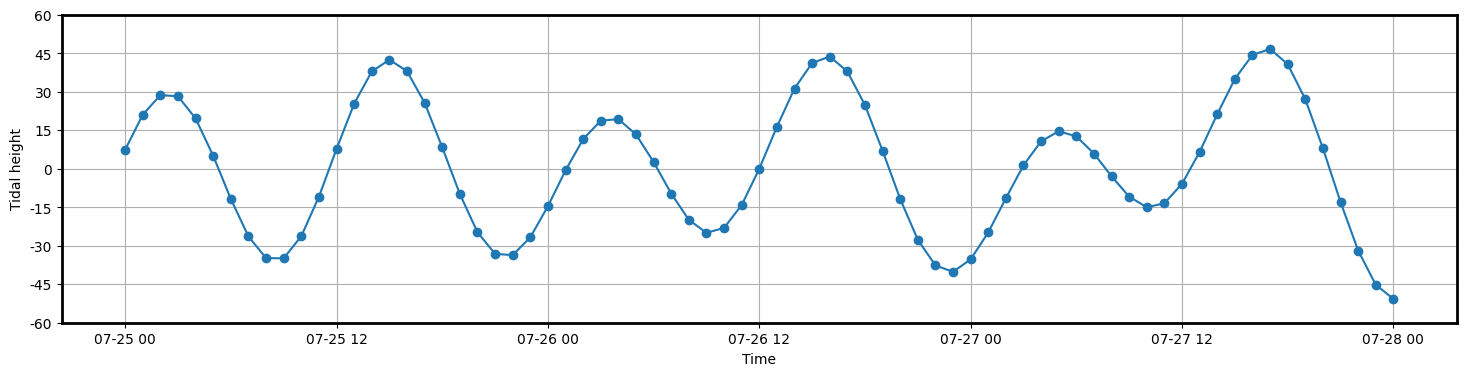

In [18]:
tide = get_tide(amp, ph, constituents, tide_time)
plot_tide(tide, dtime)

In [10]:
# available model list for current
model_list = sorted(model.global_current() + model.antarctic_current())
print(model_list)

['CATS0201', 'CATS2008', 'CATS2022', 'FES2014', 'HAMTIDE11', 'TPXO7.2', 'TPXO8-atlas', 'TPXO9-atlas', 'TPXO9-atlas-v2', 'TPXO9-atlas-v3', 'TPXO9-atlas-v4', 'TPXO9-atlas-v5', 'TPXO9.1']


In [19]:
#Try TPXO9_atlas_v5
lon = 122.26672
lat = 23.76175

# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'
tpxo9_atlas_v5 = get_tide_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [13]:
# Just test what D is...
#test_constituents = ATLAS.read_constants(tpxo9_atlas_v5.grid_file, tpxo9_atlas_v5.model_file, type=tpxo9_atlas_v5.type, compressed=tpxo9_atlas_v5.compressed)
#test_amp, test_ph, test_D = ATLAS.interpolate_constants(
#                    np.atleast_1d(lon), np.atleast_1d(lat),
#                    test_constituents, type=tpxo9_atlas_v5.type, scale=tpxo9_atlas_v5.scale,
#                    method='spline', extrapolate=True)
#print(test_D)                    

[2991.8019920574575]


In [10]:
tpxo_constituents, tpxo_amp, tpxo_ph = get_tide_constants(lon, lat, tpxo9_atlas_v5, tpxo_model_name)
print(tpxo_amp)
print(tpxo_ph)
print(len(tpxo_constituents))
print(tpxo_amp.shape)
print(tpxo_ph.shape)

[[0.03046309280395508 0.15141995239257813 0.057218879699707036
  0.17749647521972656 0.08886506652832031 0.4594989013671875
  0.0022360680103302 0.186410888671875 0.052009761810302736
  0.003605551242828369 0.001 0.0014142135381698608 0.012041594505310059
  0.003605551242828369 0.0044721360206604]]
[[66.80140842250243 77.79952928821871 95.0131154684574 97.44532534133144
  289.04662886407357 297.6163169515268 63.434951614575716
  321.06508720242175 322.02818827162315 303.69006608605525 -0.0
  224.99999965837733 265.2363571909773 33.69006859053339
  26.56505088990245]]
15
(1, 15)
(1, 15)


In [ ]:
# Plot tidal height
def plot_tide(tide, dtime):
    miny=-60
    maxy=60
    intervaly=15
    plt.figure(figsize=(18,4))
    plt.plot(dtime, tide.data, marker='o')
    plt.xlabel('Time')
    plt.ylabel('Tidal height')
    plt.yticks(list(range(miny,maxy+1,intervaly)),[str(i) for i in range(miny,maxy+1,intervaly)])
    plt.grid()
    plt.show()

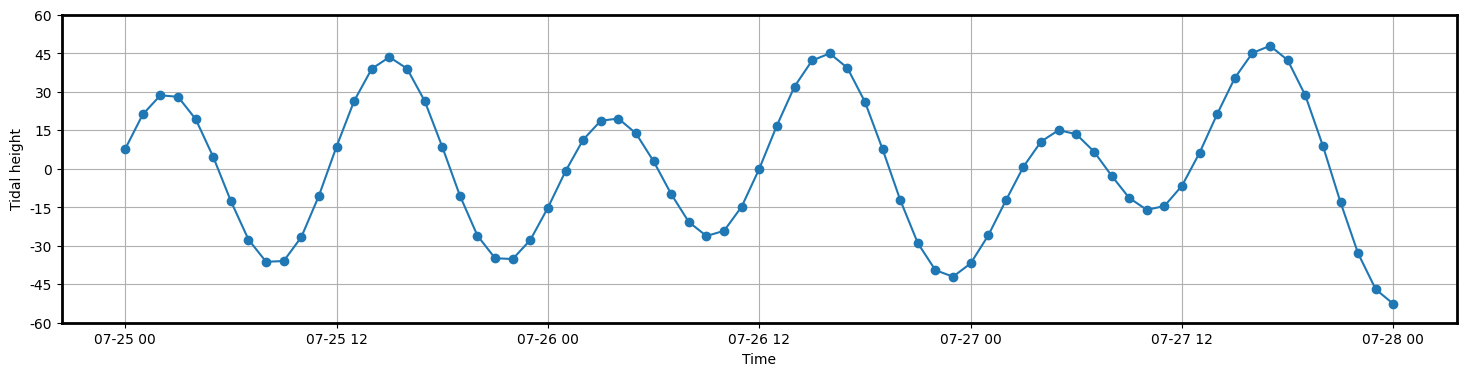

In [14]:
tpxo_tide = get_tide(tpxo_amp, tpxo_ph, tpxo_constituents, tide_time)
plot_tide(tpxo_tide, dtime)

In [ ]:
import numpy as np

def bbox2grid(x0, y0, x1, y1, gridx=0.25, gridy=0.25, biasx=0.25/2, biasy=0.25/2):
    # Check if x0=x1, or x1 is absent
    if x0 == x1 or x1 is None:
        gx = np.array([x0])
    else:
        gx = np.arange(x0 + biasx, x1 - biasx + gridx, gridx)
    
    # Check if y0=y1, or y1 is absent
    if y0 == y1 or y1 is None:
        gy = np.array([y0])
    else:
        gy = np.arange(y0 + biasy, y1 - biasy + gridy, gridy)

    glon, glat = np.meshgrid(gx, gy, indexing='xy')
    return glon, glat

# Test the function
x0, y0, x1, y1 = -180, -90, 180, 90
grid = 0.25
glon, glat = bbox2grid(x0, y0, x1, y1, grid, grid)

print(glon.shape)  # (721, 1441) - for grid=0.25
print(glat.shape)  # (721, 1441) - for grid=0.25
print(glon)
print(glat)


In [29]:
# Test the function
x0, y0, x1, y1 = -30.0, 15, 0, 35
#x0, y0, x1, y1 = 118.0, 20.0, 129.75, 31.25 
#x0, y0, x1, y1 = 122.26672, 23.76175, 129.75, 31.25
grid = 0.25
bias = 0.25/2
glon, glat = bbox2grid(x0, y0, x1, y1, grid, grid, bias, bias)

print(glon.shape) 
print(glat.shape) 
print(glon)
print(glat)
print(glon.ravel())
print(glat.ravel())
print(len(glon.ravel()))
print(isinstance(glon, np.ndarray))
print(glon.ndim)
print(glon.ravel().ndim)

(80, 120)
(80, 120)
[[-29.875 -29.625 -29.375 ...  -0.625  -0.375  -0.125]
 [-29.875 -29.625 -29.375 ...  -0.625  -0.375  -0.125]
 [-29.875 -29.625 -29.375 ...  -0.625  -0.375  -0.125]
 ...
 [-29.875 -29.625 -29.375 ...  -0.625  -0.375  -0.125]
 [-29.875 -29.625 -29.375 ...  -0.625  -0.375  -0.125]
 [-29.875 -29.625 -29.375 ...  -0.625  -0.375  -0.125]]
[[15.125 15.125 15.125 ... 15.125 15.125 15.125]
 [15.375 15.375 15.375 ... 15.375 15.375 15.375]
 [15.625 15.625 15.625 ... 15.625 15.625 15.625]
 ...
 [34.375 34.375 34.375 ... 34.375 34.375 34.375]
 [34.625 34.625 34.625 ... 34.625 34.625 34.625]
 [34.875 34.875 34.875 ... 34.875 34.875 34.875]]
[-29.875 -29.625 -29.375 ...  -0.625  -0.375  -0.125]
[15.125 15.125 15.125 ... 34.875 34.875 34.875]
9600
True
2
1


In [20]:
# Create current model object
def get_current_model(model_name, model_directory, model_format, compressed=False):
    return model(model_directory, format=model_format, compressed=compressed).current(model_name)

tpxo_curr_model = get_current_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [20]:
print(tpxo_curr_model.model_file)

{'u': [PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_ms4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/p

In [18]:
print(lon, lat)
print(np.atleast_1d(lon), np.atleast_1d(lat))

122.26672 23.76175
[122.26672] [23.76175]


In [21]:
# Load and interpolate tidal current constants
def get_current_constants(lon, lat, current_model, model_name, TYPE):
    if 'atlas' in model_name:
        amp,ph,D,c = ATLAS.extract_constants(
            np.atleast_1d(lon), np.atleast_1d(lat),
            current_model.grid_file,
            current_model.model_file[TYPE], type=TYPE, method='spline',
            scale=current_model.scale, compressed=current_model.compressed)
                
    return amp, ph, D, c

In [22]:
tpxo_u_amp, tpxo_u_ph, tpxo_u_D, tpxo_u_c = get_current_constants(lon, lat, tpxo_curr_model, tpxo_model_name, "u")


In [23]:
print(tpxo_u_amp)
print(tpxo_u_ph)
print(tpxo_u_amp.shape)
print(tpxo_u_ph.shape)
print(tpxo_u_D)
print(tpxo_u_c)

[[9.497873400927286 46.81641131373324 16.44679218374848 58.00365638385176
  6.710343381987292 40.980488366118536 1.7015621871261966
  11.546055716338426 3.70831987625335 0.27772519012342267
  0.12878326059276918 0.024780699943569205 1.152981385714734
  1.3117328841015237 1.1052506814828684]]
[[250.54912138094292 286.7758163612869 304.24214344647817
  325.33106626366083 167.13609502804601 188.94231087885615
  185.24888608517173 215.09533743726675 193.77544835820555
  144.86844889975384 209.81629788814223 46.92476222072702
  117.40443583205099 74.65462332639969 207.75599864576455]]
(1, 15)
(1, 15)
[2997.0543274819684]
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']


In [ ]:
tmp_u_amp, tmp_u_ph, tmp_u_D, tmp_u_c = get_current_constants(glon.ravel(), glat.ravel(), tpxo_curr_model, tpxo_model_name, "u")
print(tmp_u_amp)
print(tmp_u_ph)
print(tmp_u_amp.shape)
print(tmp_u_ph.shape)

In [24]:
def get_current(ilon, ilat, tide_time, current_model, model_name):
    DELTAT = np.zeros_like(tide_time)
    timelen = len(tide_time)
    lon = ilon.ravel()
    lat = ilat.ravel()
    nx = ilon.shape[1]
    ny = ilon.shape[0] #shape of ilon, ilat should be the same!
    tide = {}

    for TYPE in ['u', 'v']:
        amp, ph, D, c = get_current_constants(lon, lat, current_model, model_name, TYPE)
        # calculate complex phase in radians for Euler's
        cph = -1j * ph * np.pi / 180.0
        # calculate constituent oscillation
        hc = amp * np.exp(cph)
        tide[TYPE] = np.ma.zeros((ny, nx, timelen))

        for hour in range(timelen):
            # predict tidal elevations at time and infer minor corrections
            TIDE = map(tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=current_model.format)
            MINOR = infer_minor(tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=current_model.format)
            # add major and minor components and reform grid
            # Reshape TIDE and MINOR to have the shape (ny, nx)
            tide[TYPE][:,:,hour] = np.reshape((TIDE+MINOR),(ny,nx))
               
    return tide

In [31]:
gtide = get_current(glon, glat, tide_time[0:1], tpxo_curr_model, tpxo_model_name)

/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/pyTMD-2.0.6.dev8+gb8f2a2a-py3.11.egg/pyTMD/io/ATLAS.py:333: RuntimeWarning: divide by zero encountered in divide
  ampl.data[:,i] = np.abs(hci.data)/unit_conv


In [32]:
# Set the time index (0 to 23)
t = 0
nx = glon.shape[1]
ny = glon.shape[0] #shape of glon, glat should be the same!

# Reshape u and v to 2D
u0 = gtide['u'][:,:,t] #.reshape(ny, nx)
v0 = gtide['v'][:,:,t] #.reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

# Calculate magnitude of the current
magnitude = np.sqrt(u0**2 + v0**2)

# Normalize the arrows to create a uniform arrow size across the plot
u = u0/magnitude
v = v0/magnitude

print(magnitude)
print(u)
print(v)

n = 1
mask = (X % n == 0) & (Y % n == 0)

x = glon[mask]
y = glat[mask]
u = u[mask]
v = v[mask]
mag = magnitude[mask]*0.01

[[46.36699436437715 46.30251580333035 46.029553888110605 ... -- -- --]
 [48.4962551429522 48.34735814696807 47.78280375831865 ... -- -- --]
 [50.957386162844244 50.813523201491705 49.79345584236987 ... -- -- --]
 ...
 [203.10132466289267 188.44714669451318 191.15436951883814 ... -- -- --]
 [192.7401074456579 185.40222962676327 186.6889136653806 ... -- -- --]
 [189.0761924473027 188.3487143309253 189.77269617312578 ... -- -- --]]
[[-0.9804554122582927 -0.9719204313194326 -0.9591905250222523 ... -- --
  --]
 [-0.9878842579650705 -0.9824870152118951 -0.9738236464277462 ... -- --
  --]
 [-0.9928587504321882 -0.9896630233010124 -0.9842571142746014 ... -- --
  --]
 ...
 [-0.9237520311635216 -0.901334658915927 -0.9027031154861802 ... -- -- --]
 [-0.9404816502782223 -0.9245904175569561 -0.9142817669715981 ... -- --
  --]
 [-0.9411057349721308 -0.930764674107105 -0.9212683889294592 ... -- -- --]]
[[0.19674141550121368 0.23530974307037958 0.28276056427220514 ... -- --
  --]
 [0.15519243816888062

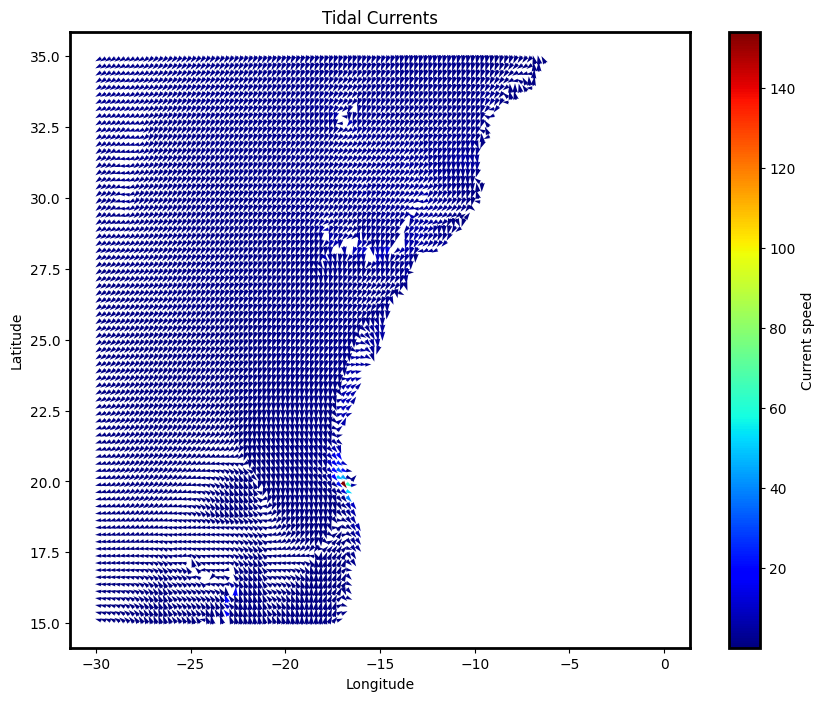

In [33]:
# Calculate magnitude of the current
# Create a figure and plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting, note the "angles" and "scale" parameters
plt.colorbar(ax.quiver(x, y, u, v, mag, 
                       angles='xy', scale_units='xy', 
                       scale=3, pivot='middle', width=0.003, cmap='jet'), 
             ax=ax, label='Current speed')

ax.set_title('Tidal Currents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.show()